In [1]:
import sys
sys.path.append('../src/')
import os
import math
import itertools
import numpy as np
import pandas as pd
import scipy
import gpytorch
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

import evaluation_metrics as evaluation_metrics
from models import *
from priors import *
from utils import *

In [3]:
def print_metrics(model_objects, X_test, y_test):
    model, *likelihood_objects = model_objects
    label_map = { PowerLaw: 'Power law', Arctan: 'Arctan', GPPowerLaw: 'GP power law (ours)', GPArctan: 'GP arctan (ours)' }
    label = label_map.get(type(model), 'Unknown') # Default label is 'Unknown' 
    if label.startswith('GP'):
        likelihood, = likelihood_objects
        with torch.no_grad(): predictions = likelihood(model(X_test))
        loc = predictions.mean.numpy()
        scale = predictions.stddev.numpy()
        lower, upper = truncated_normal_uncertainty(0.0, 1.0, loc, scale)   
        error = evaluation_metrics.rmse(y_test.detach().numpy(), loc)
        upm = uniform_probability_mass(y_test.detach().numpy(), torch.min(y_train).item(), 1-torch.min(y_train).item())
        tpm = truncnorm_probability_mass(y_test.detach().numpy(), 0.0, 1.0, loc, scale)
        coverage_95 = evaluation_metrics.coverage(y_test.detach().numpy(), lower, upper)
        lower, upper = truncated_normal_uncertainty(0.0, 1.0, loc, scale, 0.1, 0.9)
        coverage_80 = evaluation_metrics.coverage(y_test.detach().numpy(), lower, upper)
        print('{} RMSE: {:.4f}'.format(label, 100*error))
        print('Uniform probability mass: {:.4f}'.format(upm))
        print('{} probability mass: {:.4f}'.format(label, tpm))
        print('{} 80% coverage: {:.2f}%'.format(label, 100*coverage_80))      
        print('{} 95% coverage: {:.2f}%'.format(label, 100*coverage_95))      
    else:
        with torch.no_grad(): loc = model(X_test).detach().numpy()
        error = evaluation_metrics.rmse(y_test.detach().numpy(), loc)
        print('{} RMSE: {:.4f}'.format(label, 100*error))
    print()
    
def plot_data(ax, X_train, y_train, X_test, y_test):
    ax.scatter(X_train, y_train, color='black', alpha=1.0, label='Initial subsets')
    ax.scatter(X_test, y_test, color='black', alpha=0.3, label='Ground truth')

def load_model(name, path, X_train, y_train):
    model_map = { 'PowerLaw': PowerLaw, 'Arctan': Arctan, 'GPPowerLaw': GPPowerLaw, 'GPArctan': GPArctan }
    model_class = model_map[name]
    if name.startswith('GP'):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = model_class(X_train, y_train, likelihood)
        model.load_state_dict(torch.load(path))
        likelihood.eval()
        model.eval()
        return model, likelihood
    else:
        model = model_class(y_train[-1].item())
        model.load_state_dict(torch.load(path))
        model.eval()
        return model,

def plot_model(ax, model_objects, color='black'):
    model, *likelihood_objects = model_objects
    label_map = { PowerLaw: 'Power law', Arctan: 'Arctan', GPPowerLaw: 'GP power law (ours)', GPArctan: 'GP arctan (ours)' }
    label = label_map.get(type(model), 'Unknown') # Default label is 'Unknown' 
    if label.startswith('GP'):
        likelihood, = likelihood_objects
        with torch.no_grad(): predictions = likelihood(model(torch.linspace(100, 30000, 1000)))
        loc = predictions.mean.numpy()
        scale = predictions.stddev.numpy()
        lower, upper = truncated_normal_uncertainty(0.0, 1.0, loc, scale)   
        ax.plot(np.linspace(100, 30000, 1000), loc, color=color, label=label)
        ax.fill_between(np.linspace(100, 30000, 1000), lower, upper, color=color, alpha=0.1)
    else:
        with torch.no_grad(): loc = model(torch.linspace(100, 30000, 1000))
        ax.plot(np.linspace(100, 30000, 1000), loc, color=color, label=label)
        
def format_plot(ax, label):
    ax.set_ylim([0.5, 1.0])
    ax.set_xscale('log')
    ax.set_xlabel('Number of training samples (log-scale)')
    ax.set_ylabel('{} AUROC'.format(label))

In [4]:
repo_path = '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets'
experiments_path = os.path.join(repo_path, 'experiments')
models_path = os.path.join(repo_path, 'models')

Power law RMSE: 2.6459

GP power law (ours) RMSE: 2.5530
Uniform probability mass: 0.1243
GP power law (ours) probability mass: 0.4365
GP power law (ours) 80% coverage: 83.33%
GP power law (ours) 95% coverage: 100.00%

Power law RMSE: 1.4932

GP power law (ours) RMSE: 0.8843
Uniform probability mass: 0.1552
GP power law (ours) probability mass: 0.6256
GP power law (ours) 80% coverage: 100.00%
GP power law (ours) 95% coverage: 100.00%

Power law RMSE: 4.2060

GP power law (ours) RMSE: 4.3591
Uniform probability mass: 0.0988
GP power law (ours) probability mass: 0.2950
GP power law (ours) 80% coverage: 50.00%
GP power law (ours) 95% coverage: 100.00%



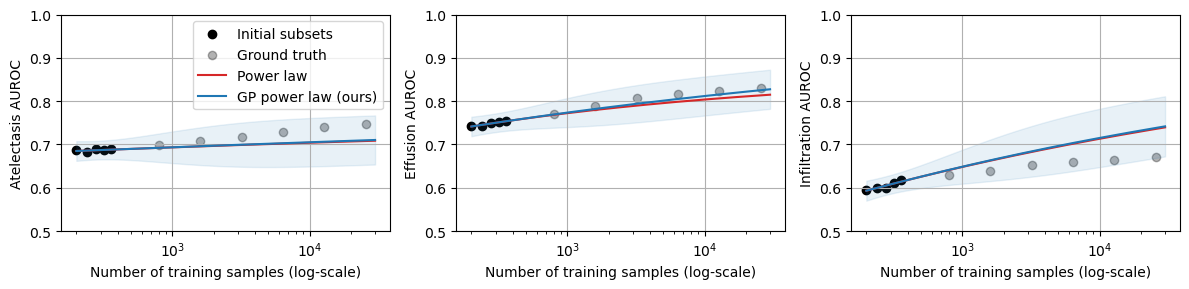

In [14]:
labels = ['Atelectasis', 'Effusion', 'Infiltration']
models = ['PowerLaw', 'GPPowerLaw']
colors = ['#d62728', '#1f77b4']

dataset_name, filename = 'ChestX-ray14', 'ChestX-ray14_long_range.csv'
df = load_experiment(os.path.join(experiments_path, filename))
# Take mean of each random seed at each dataset size
df = df.groupby('n').agg(lambda x: list(x))
df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
df.random_state = df.random_state.apply(lambda x: 'mean')
df = df.reset_index()

ncols, nrows = 3, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
for label_index, label_name in enumerate(labels):
    # Plot data
    X_train, y_train, X_test, y_test = split_df(df, index=label_index)
    plot_data(np.array(axs).flatten()[label_index], X_train, y_train, X_test, y_test)
    # Load model
    for model_name, color in zip(models, colors):
        model_filename = '{}_{}_{}.pt'.format(dataset_name, label_name, model_name)
        model_filepath = os.path.join(models_path, model_filename)
        model_objects = load_model(model_name, model_filepath, X_train, y_train)
        print_metrics(model_objects, X_test, y_test)
        plot_model(np.array(axs).flatten()[label_index], model_objects, color)
    format_plot(np.array(axs).flatten()[label_index], label_name)
# Add legend to left most plot        
np.array(axs).flatten()[ncols*(nrows-1)].legend()
# Set grid for each plot
for i in range(ncols*nrows): np.array(axs).flatten()[i].grid()
fig.tight_layout()
plt.show()

GP power law (ours) RMSE: 1.0859
Uniform probability mass: 0.5566
GP power law (ours) probability mass: 0.8162
GP power law (ours) 80% coverage: 50.00%
GP power law (ours) 95% coverage: 100.00%

GP arctan (ours) RMSE: 0.8576
Uniform probability mass: 0.5566
GP arctan (ours) probability mass: 0.8684
GP arctan (ours) 80% coverage: 83.33%
GP arctan (ours) 95% coverage: 100.00%

GP power law (ours) RMSE: 1.7441
Uniform probability mass: 0.2091
GP power law (ours) probability mass: 0.5890
GP power law (ours) 80% coverage: 33.33%
GP power law (ours) 95% coverage: 100.00%

GP arctan (ours) RMSE: 1.7445
Uniform probability mass: 0.2091
GP arctan (ours) probability mass: 0.5889
GP arctan (ours) 80% coverage: 33.33%
GP arctan (ours) 95% coverage: 100.00%

GP power law (ours) RMSE: 0.4036
Uniform probability mass: 0.1858
GP power law (ours) probability mass: 0.9263
GP power law (ours) 80% coverage: 100.00%
GP power law (ours) 95% coverage: 100.00%

GP arctan (ours) RMSE: 0.4037
Uniform probabilit

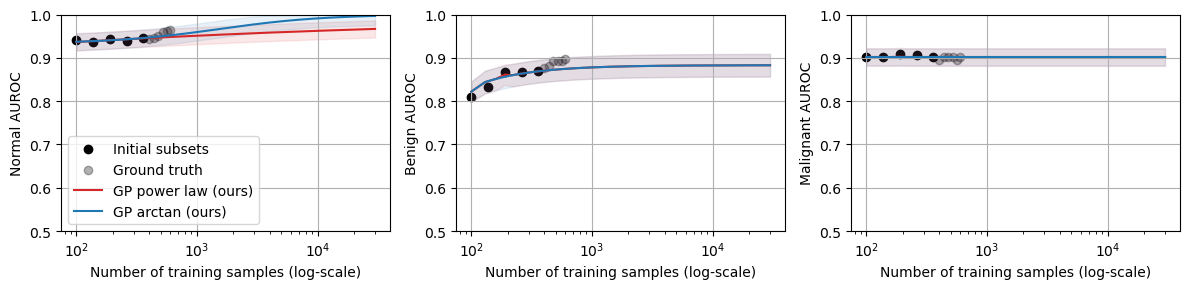

In [7]:
labels = ['Normal', 'Benign', 'Malignant']
models = ['GPPowerLaw', 'GPArctan']
colors = ['#d62728', '#1f77b4']

dataset_name, filename = 'BUSI', 'BUSI_short_range(d).csv'
df = load_experiment(os.path.join(experiments_path, filename))
# Take mean of each random seed at each dataset size
df = df.groupby('n').agg(lambda x: list(x))
df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
df.random_state = df.random_state.apply(lambda x: 'mean')
df = df.reset_index()

ncols, nrows = 3, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
for label_index, label_name in enumerate(labels):
    # Plot data
    X_train, y_train, X_test, y_test = split_df(df, index=label_index)
    plot_data(np.array(axs).flatten()[label_index], X_train, y_train, X_test, y_test)
    # Load model
    for model_name, color in zip(models, colors):
        model_filename = 'BUSI (b)/{}_{}_{}.pt'.format(dataset_name, label_name, model_name)
        model_filepath = os.path.join(models_path, model_filename)
        model_objects = load_model(model_name, model_filepath, X_train, y_train)
        print_metrics(model_objects, X_test, y_test)
        plot_model(np.array(axs).flatten()[label_index], model_objects, color)
    format_plot(np.array(axs).flatten()[label_index], label_name)
# Add legend to left most plot        
np.array(axs).flatten()[ncols*(nrows-1)].legend()
# Set grid for each plot
for i in range(ncols*nrows): np.array(axs).flatten()[i].grid()
fig.tight_layout()
plt.show()

In [ ]:
dataset_name, filename = 'ChestX-ray14', 'ChestX-ray14_long_range.csv'
df = load_experiment(os.path.join(experiments_path, filename))
# Take mean of each random seed at each dataset size
df = df.groupby('n').agg(lambda x: list(x))
df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
df.random_state = df.random_state.apply(lambda x: 'mean')
df = df.reset_index()

label_index = 2
plot_objects = zip(['Infiltration', 'Infiltration'], ['PowerLaw', 'GPPowerLaw'], ['#d62728', '#1f77b4'])
ncols, nrows = 2, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
for subplot_index, (label_name, model_name, color) in enumerate(plot_objects):
    # Plot data
    X_train, y_train, X_test, y_test = split_df(df, index=label_index)
    plot_data(np.array(axs).flatten()[subplot_index], X_train, y_train, X_test, y_test)
    # Load model
    model_filename = '{}_{}_{}.pt'.format(dataset_name, label_name, model_name)
    model_filepath = os.path.join(models_path, model_filename)
    model_objects = load_model(model_name, model_filepath, X_train, y_train)
    print_metrics(model_objects, X_test, y_test)
    plot_model(np.array(axs).flatten()[subplot_index], model_objects, color)
    format_plot(np.array(axs).flatten()[subplot_index], label_name)
    np.array(axs).flatten()[subplot_index].legend()
# Set grid for each plot
for i in range(ncols*nrows): np.array(axs).flatten()[i].grid()
fig.tight_layout()
plt.show()

0
GP power law (ours) RMSE: 0.3387
Uniform probability mass: 0.0973
GP power law (ours) probability mass: 0.8580
GP power law (ours) 80% coverage: 100.0000
GP power law (ours) 95% coverage: 100.0000

GP arctan (ours) RMSE: 0.1921
Uniform probability mass: 0.0973
GP arctan (ours) probability mass: 0.8663
GP arctan (ours) 80% coverage: 100.0000
GP arctan (ours) 95% coverage: 100.0000

1
GP power law (ours) RMSE: 0.6813
Uniform probability mass: 0.1533
GP power law (ours) probability mass: 0.8317
GP power law (ours) 80% coverage: 100.0000
GP power law (ours) 95% coverage: 100.0000

GP arctan (ours) RMSE: 0.6371
Uniform probability mass: 0.1533
GP arctan (ours) probability mass: 0.8389
GP arctan (ours) 80% coverage: 100.0000
GP arctan (ours) 95% coverage: 100.0000

2
GP power law (ours) RMSE: 0.8417
Uniform probability mass: 0.0979
GP power law (ours) probability mass: 0.7886
GP power law (ours) 80% coverage: 100.0000
GP power law (ours) 95% coverage: 100.0000

GP arctan (ours) RMSE: 1.578

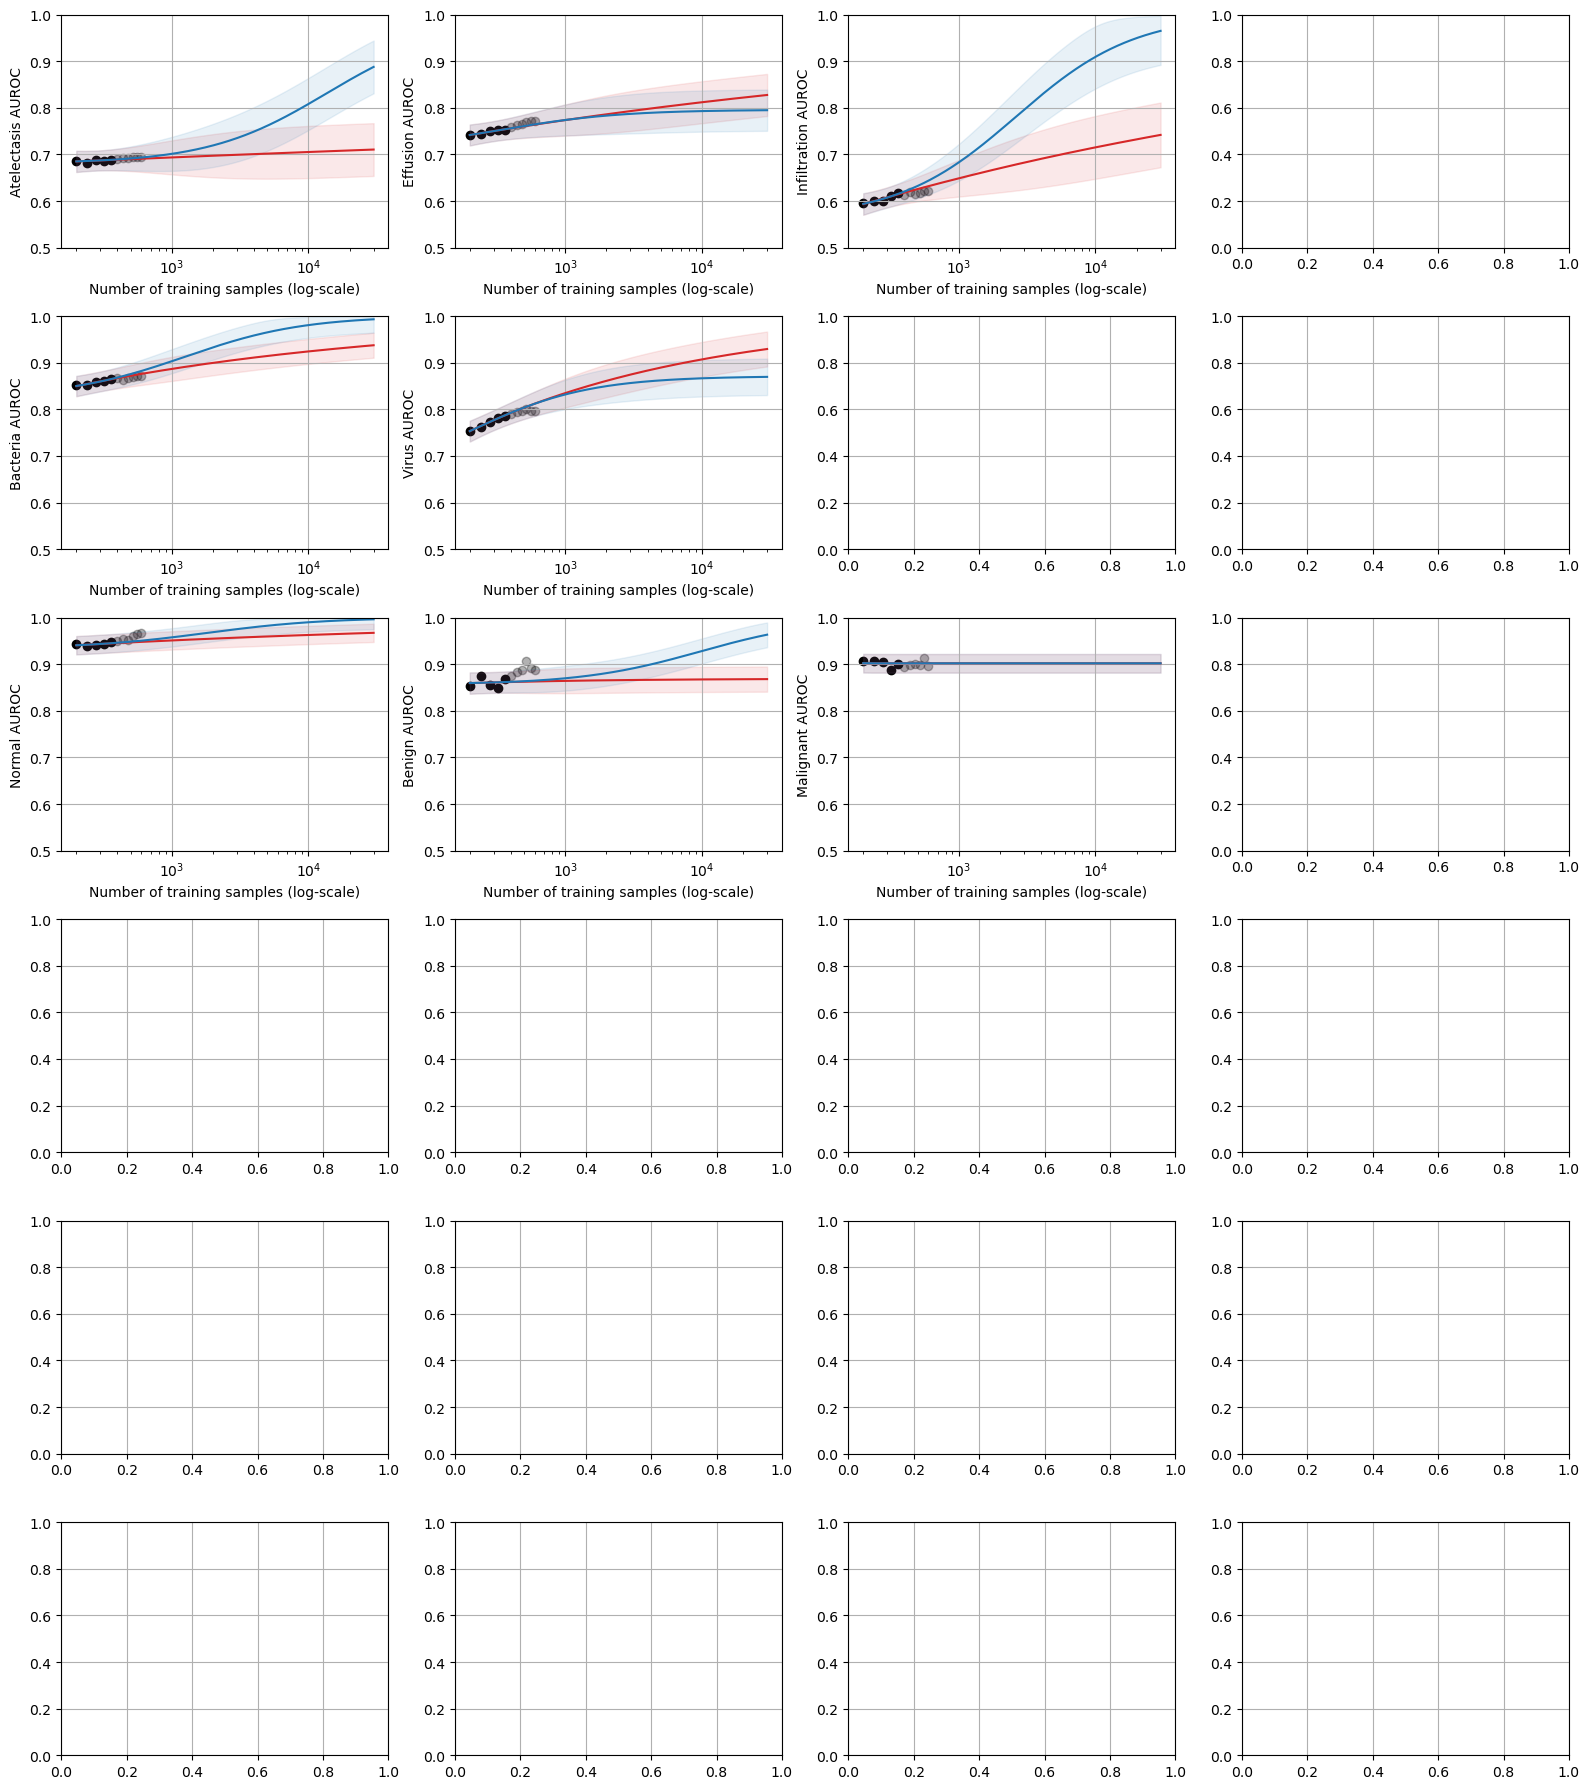

In [37]:
datasets = [('ChestX-ray14', 'ChestX-ray14_short_range.csv'),
            ('Chest_X-Ray', 'Chest_X-Ray_short_range.csv'),
            ('BUSI', 'BUSI_short_range.csv')]
labels = [['Atelectasis', 'Effusion', 'Infiltration'],
          ['Bacteria', 'Virus'],
          ['Normal', 'Benign', 'Malignant']]
models = ['GPPowerLaw', 'GPArctan']
colors = ['#d62728', '#1f77b4']

ncols, nrows = 4, 6
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

for dataset_index, dataset in enumerate(datasets):
    dataset_name, filename = dataset
    df = load_experiment(os.path.join(experiments_path, filename))
    # Take mean of each random seed at each dataset size
    df = df.groupby('n').agg(lambda x: list(x))
    df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
    df.random_state = df.random_state.apply(lambda x: 'mean')
    df = df.reset_index()

    for label_index, label_name in enumerate(labels[dataset_index]):
        subplot_index = (dataset_index*ncols)+label_index
        print(subplot_index)
        # Plot data
        X_train, y_train, X_test, y_test = split_df(df, index=label_index)
        plot_data(np.array(axs).flatten()[subplot_index], X_train, y_train, X_test, y_test)
        # Load model
        for model_name, color in zip(models, colors):
            model_filename = '{}_{}_{}.pt'.format(dataset_name, label_name, model_name)
            model_filepath = os.path.join(models_path, model_filename)
            model_objects = load_model(model_name, model_filepath, X_train, y_train)
            print_metrics(model_objects, X_test, y_test)
            plot_model(np.array(axs).flatten()[subplot_index], model_objects, color)
        format_plot(np.array(axs).flatten()[subplot_index], label_name)
# Add legend to left most plot        
np.array(axs).flatten()[8].legend()
# Set grid for each plot
for i in range(ncols*nrows): np.array(axs).flatten()[i].grid()
fig.tight_layout()
plt.show()

0
GP power law (ours) RMSE: 2.5530
Uniform probability mass: 0.1243
GP power law (ours) probability mass: 0.4365
GP power law (ours) 80% coverage: 83.3333
GP power law (ours) 95% coverage: 100.0000

GP arctan (ours) RMSE: 6.6650
Uniform probability mass: 0.1243
GP arctan (ours) probability mass: 0.3327
GP arctan (ours) 80% coverage: 50.0000
GP arctan (ours) 95% coverage: 66.6667

1
GP power law (ours) RMSE: 0.8843
Uniform probability mass: 0.1552
GP power law (ours) probability mass: 0.6256
GP power law (ours) 80% coverage: 100.0000
GP power law (ours) 95% coverage: 100.0000

GP arctan (ours) RMSE: 2.3617
Uniform probability mass: 0.1552
GP arctan (ours) probability mass: 0.4738
GP arctan (ours) 80% coverage: 66.6667
GP arctan (ours) 95% coverage: 100.0000

2
GP power law (ours) RMSE: 4.3591
Uniform probability mass: 0.0988
GP power law (ours) probability mass: 0.2950
GP power law (ours) 80% coverage: 50.0000
GP power law (ours) 95% coverage: 100.0000

GP arctan (ours) RMSE: 19.5156
Un

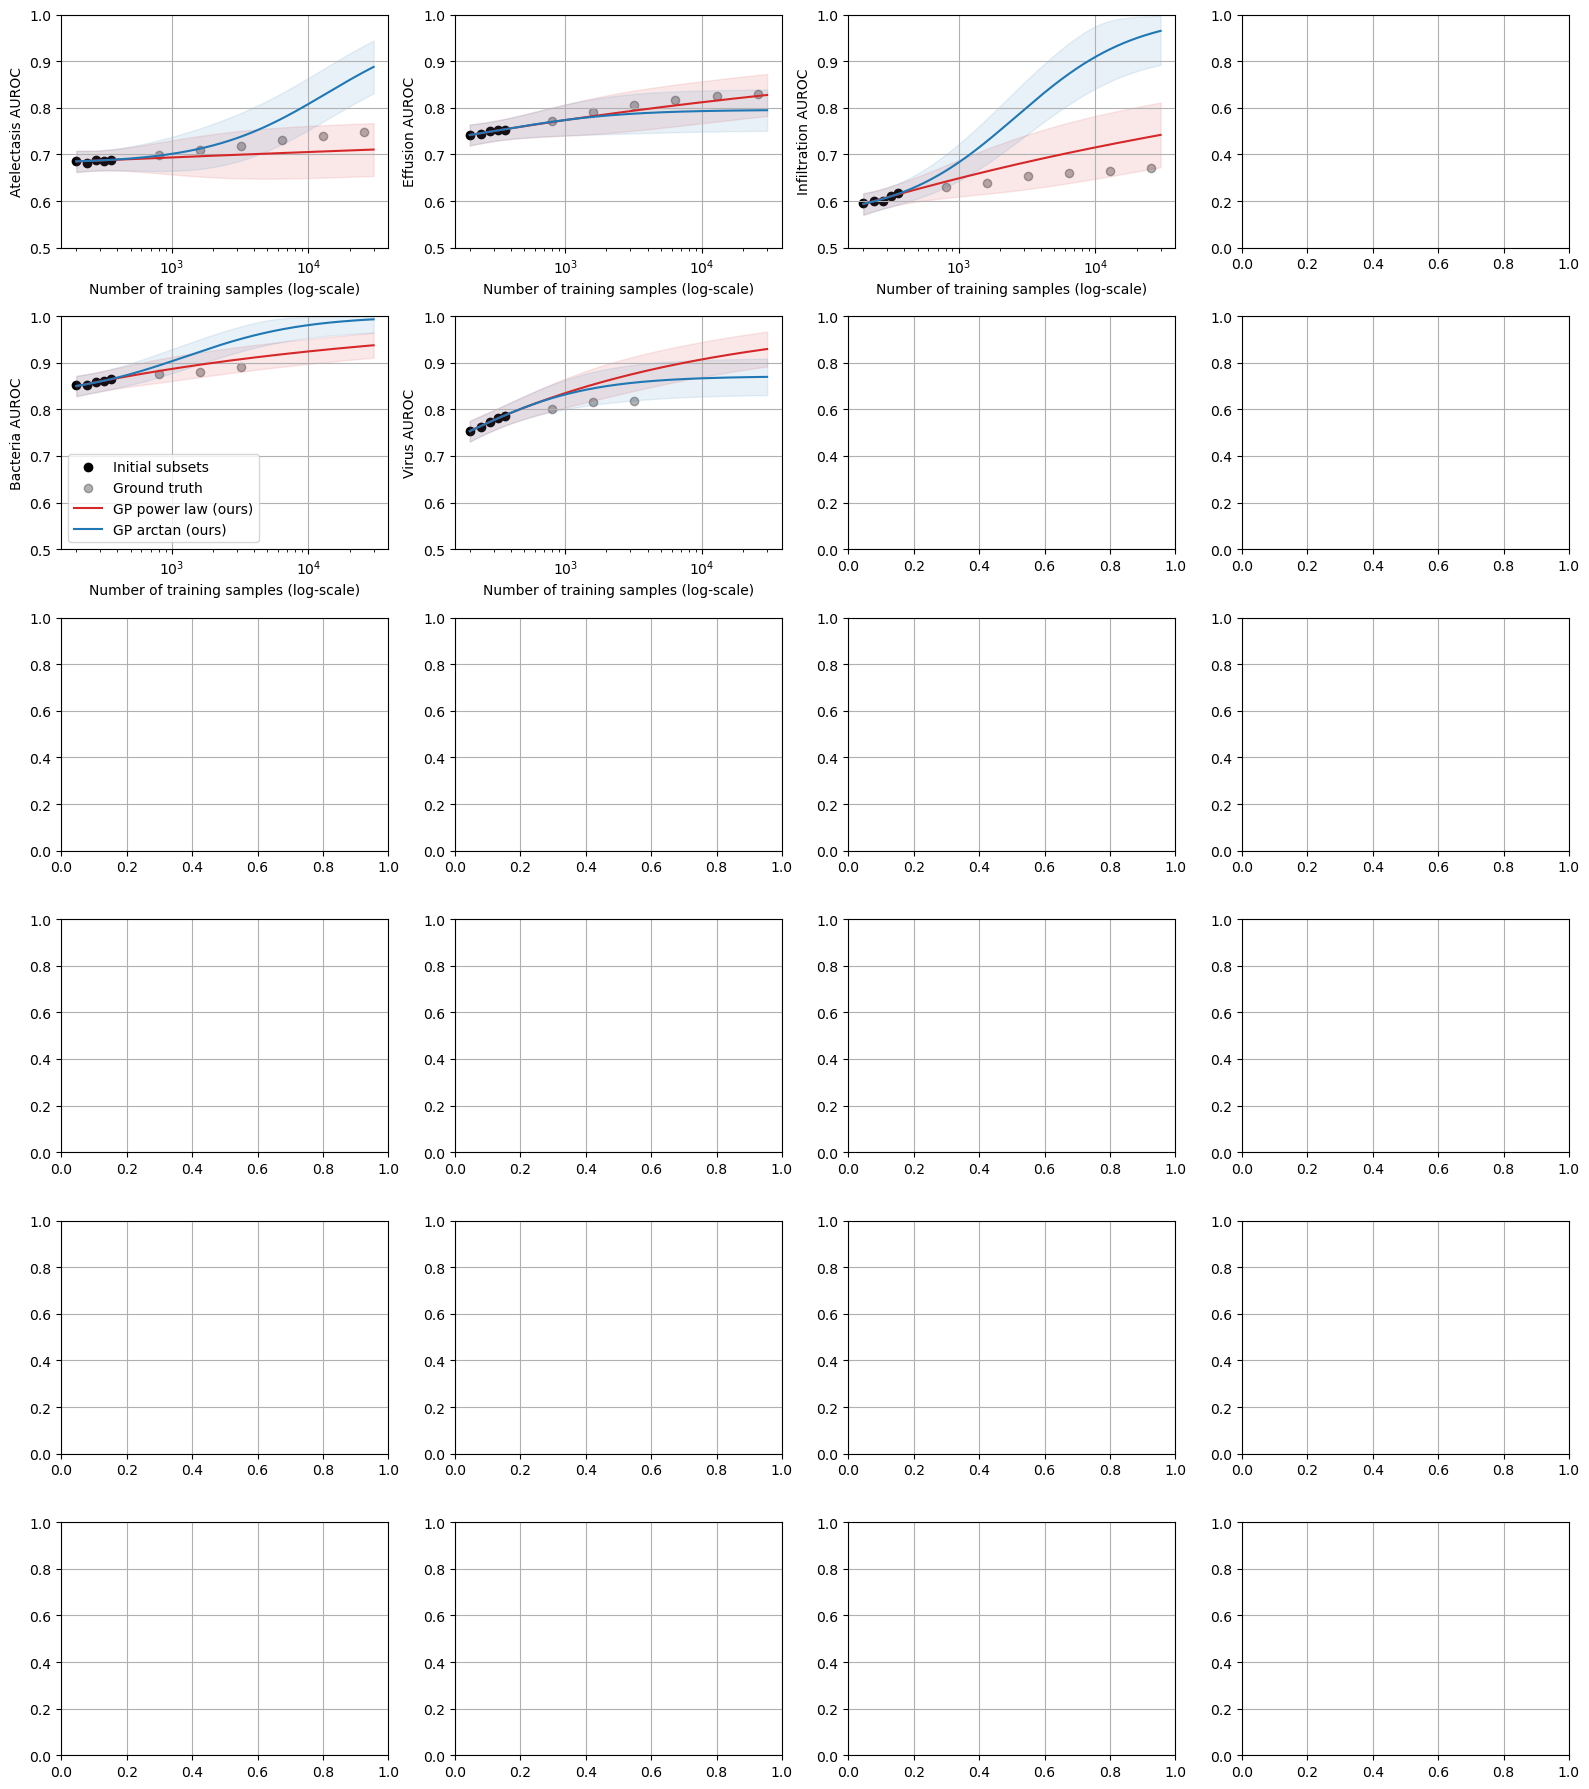

In [38]:
datasets = [('ChestX-ray14', 'ChestX-ray14_long_range.csv'),
            ('Chest_X-Ray', 'Chest_X-Ray_long_range.csv')]
labels = [['Atelectasis', 'Effusion', 'Infiltration'],
          ['Bacteria', 'Virus']]
models = ['GPPowerLaw', 'GPArctan']
colors = ['#d62728', '#1f77b4']

ncols, nrows = 4, 6
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

for dataset_index, dataset in enumerate(datasets):
    dataset_name, filename = dataset
    df = load_experiment(os.path.join(experiments_path, filename))
    # Take mean of each random seed at each dataset size
    df = df.groupby('n').agg(lambda x: list(x))
    df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
    df.random_state = df.random_state.apply(lambda x: 'mean')
    df = df.reset_index()

    for label_index, label_name in enumerate(labels[dataset_index]):
        subplot_index = (dataset_index*ncols)+label_index
        print(subplot_index)
        # Plot data
        X_train, y_train, X_test, y_test = split_df(df, index=label_index)
        plot_data(np.array(axs).flatten()[subplot_index], X_train, y_train, X_test, y_test)
        # Load model
        for model_name, color in zip(models, colors):
            model_filename = '{}_{}_{}.pt'.format(dataset_name, label_name, model_name)
            model_filepath = os.path.join(models_path, model_filename)
            model_objects = load_model(model_name, model_filepath, X_train, y_train)
            print_metrics(model_objects, X_test, y_test)
            plot_model(np.array(axs).flatten()[subplot_index], model_objects, color)
        format_plot(np.array(axs).flatten()[subplot_index], label_name)
# Add legend to left most plot        
np.array(axs).flatten()[4].legend()
# Set grid for each plot
for i in range(ncols*nrows): np.array(axs).flatten()[i].grid()
fig.tight_layout()
plt.show()

0
1
2
4
5
8
9
10


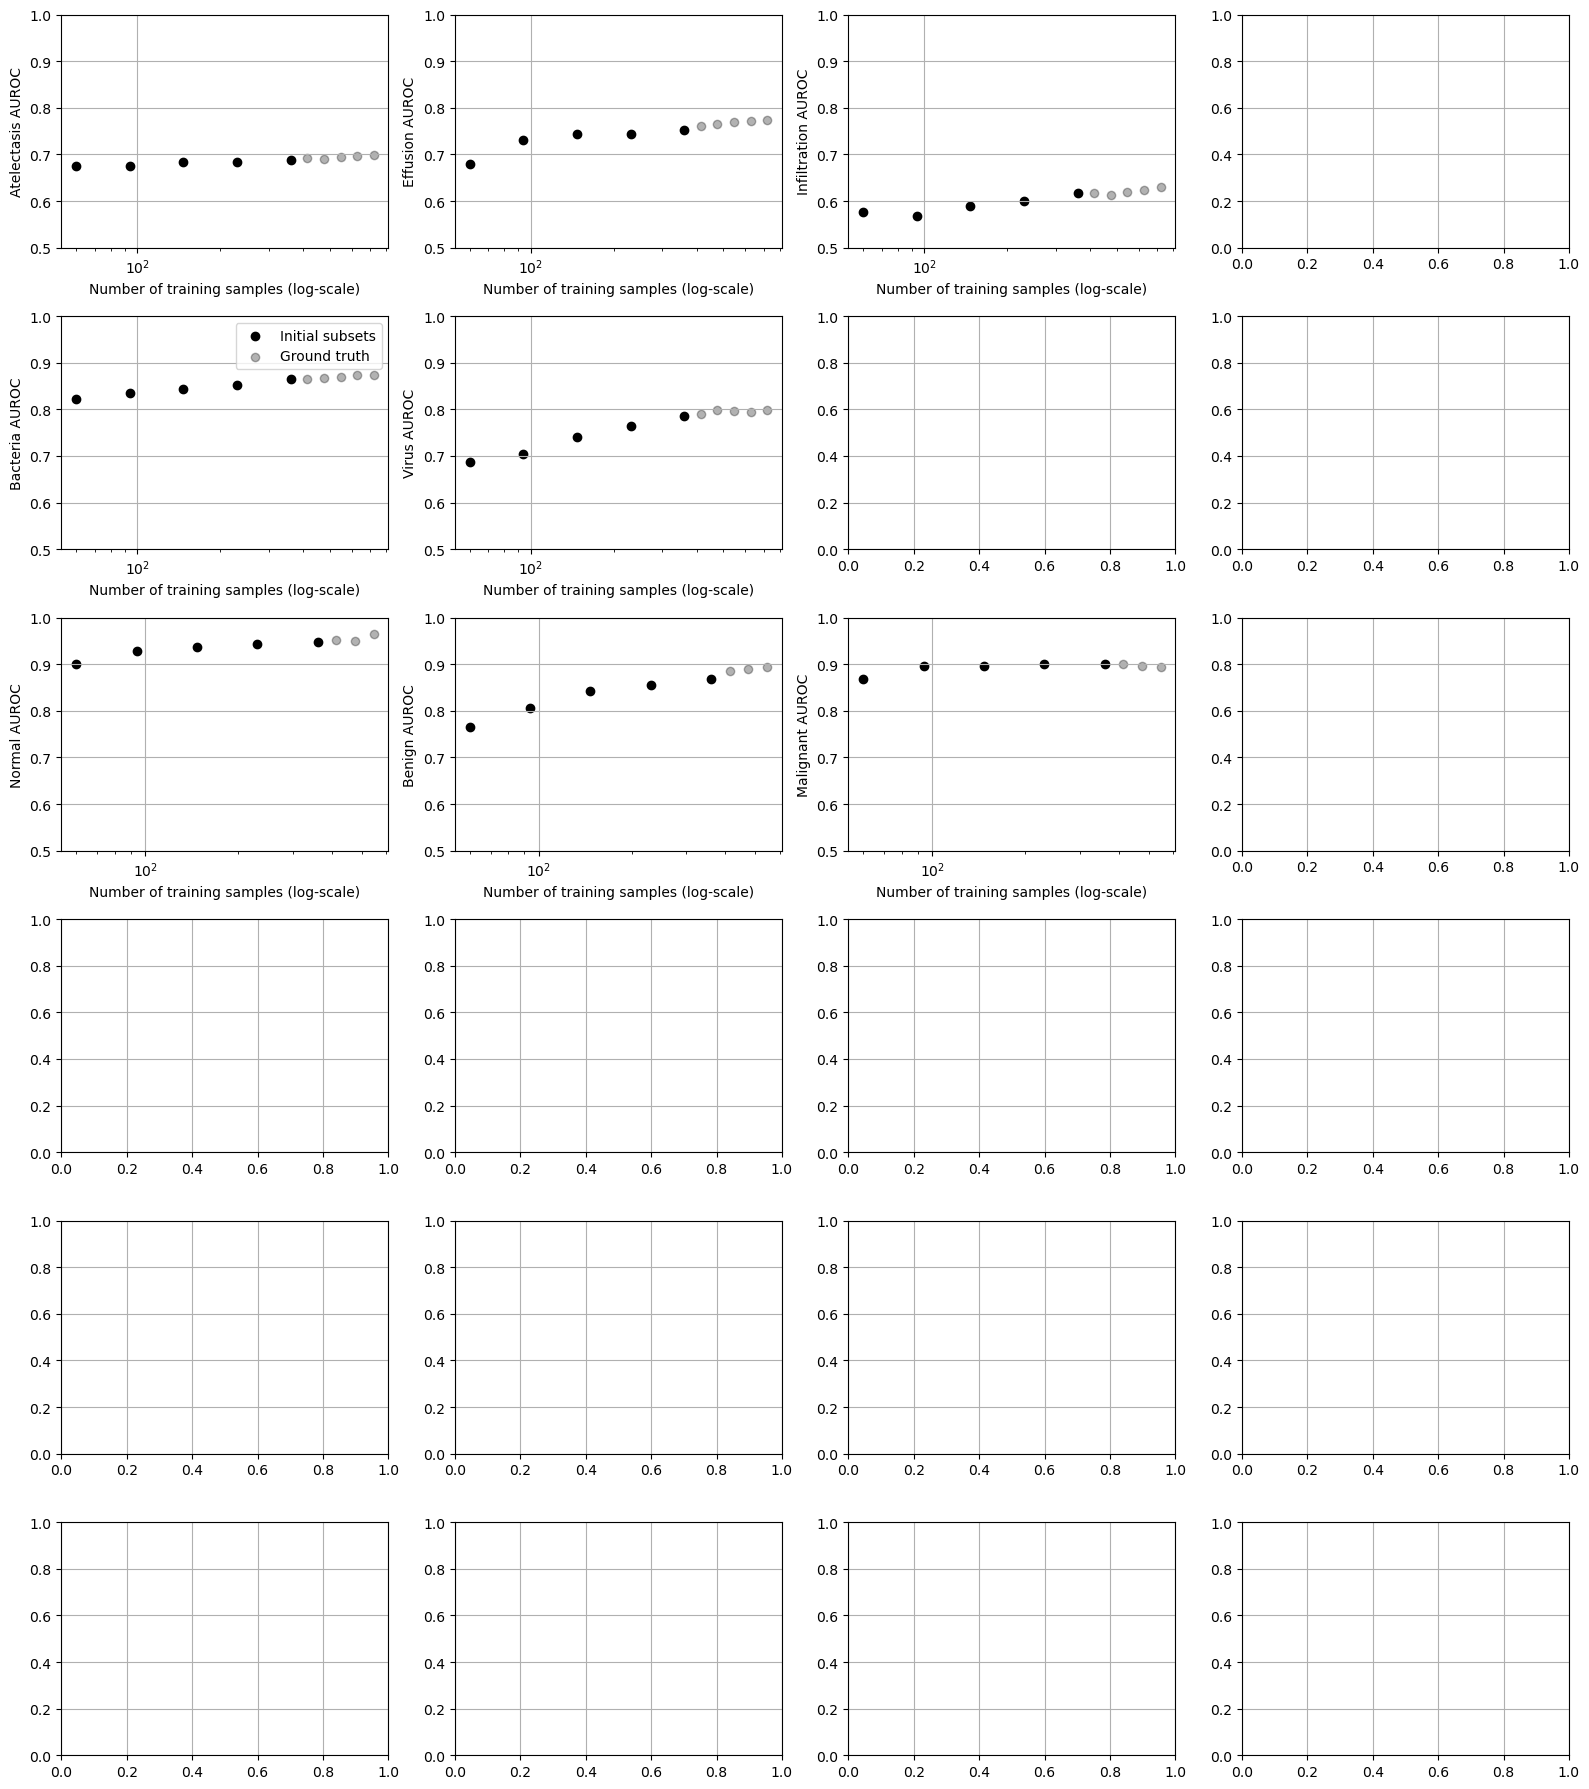

In [21]:
datasets = [('ChestX-ray14', 'ChestX-ray14_short_range.csv'),
            ('Chest_X-Ray', 'Chest_X-Ray_short_range.csv'),
            ('BUSI', 'BUSI_short_range.csv')]
labels = [['Atelectasis', 'Effusion', 'Infiltration'],
          ['Bacteria', 'Virus'],
          ['Normal', 'Benign', 'Malignant']]
models = ['GPPowerLaw', 'GPArctan']
colors = ['#d62728', '#1f77b4']

ncols, nrows = 4, 6
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

for dataset_index, dataset in enumerate(datasets):
    dataset_name, filename = dataset
    df = load_experiment(os.path.join(experiments_path, filename))
    # Take mean of each random seed at each dataset size
    df = df.groupby('n').agg(lambda x: list(x))
    df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
    df.random_state = df.random_state.apply(lambda x: 'mean')
    df = df.reset_index()
    for label_index, label_name in enumerate(labels[dataset_index]):
        subplot_index = (dataset_index*ncols)+label_index
        print(subplot_index)
        # Plot data
        X_train, y_train, X_test, y_test = split_df(df, index=label_index)
        plot_data(np.array(axs).flatten()[subplot_index], X_train, y_train, X_test, y_test)
        format_plot(np.array(axs).flatten()[subplot_index], label_name)
# Add legend to left most plot        
np.array(axs).flatten()[4].legend()
# Set grid for each plot
for i in range(ncols*nrows): np.array(axs).flatten()[i].grid()
fig.tight_layout()
plt.show()

In [ ]:
def load_experiment(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    df.train_BA = df.train_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.train_auroc = df.train_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.val_BA = df.val_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.val_auroc = df.val_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.test_BA = df.test_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.test_auroc = df.test_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    return df

In [ ]:
paths = ['/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_20k_i={}.csv'.format(i) for i in range(10)]
dataframes = [load_experiment(path) for path in paths]
stacked_df = pd.concat(dataframes, ignore_index=True)
print(stacked_df.shape)
stacked_df.head(100)
#stacked_df.to_csv('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_20k.csv')

In [ ]:
def plot_experiment(df, df5k, df10k, df20k, labels):
    # Take mean of each random seed at each dataset size
    df = df.groupby('n').agg(lambda x: list(x))
    df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
    df.random_state = df.random_state.apply(lambda x: 'mean')
    df = df.reset_index()
    
    ncols = len(labels) if len(labels) < 4 else 4
    nrows = math.ceil(len(labels)/4)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), dpi=300)
    
    group_size = 3
    df5k['group'] = (df5k.index // group_size) + 1
    df5k = df5k.groupby('group').test_auroc.agg(lambda x: list(x)).reset_index()
    test_aurocs_df5k = np.array(df5k.test_auroc.tolist())
    # _, label, group
    mean_test_aurocs_df5k = np.mean(test_aurocs_df5k, axis=1)
    
    df10k['group'] = (df10k.index // group_size) + 1
    df10k = df10k.groupby('group').test_auroc.agg(lambda x: list(x)).reset_index()
    test_aurocs_df10k = np.array(df10k.test_auroc.tolist())
    # _, label, group
    mean_test_aurocs_df10k = np.mean(test_aurocs_df10k, axis=1)

    df20k['group'] = (df20k.index // group_size) + 1
    df20k = df20k.groupby('group').test_auroc.agg(lambda x: list(x)).reset_index()
    test_aurocs_df20k = np.array(df20k.test_auroc.tolist())
    # _, label, group
    mean_test_aurocs_df20k = np.mean(test_aurocs_df20k, axis=1)

    for label_index, _ in enumerate(labels):
        # Plot data
        temp_df = df[df.random_state=='mean']
        np.array(axs).flatten()[label_index]\
        .scatter(temp_df[temp_df.n<=360].n.to_numpy(),
                 np.array(temp_df[temp_df.n<=360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=1.0,
                 label='Initial subsets')
        np.array(axs).flatten()[label_index]\
        .scatter(temp_df[temp_df.n>360].n.to_numpy(),
                 np.array(temp_df[temp_df.n>360].test_auroc.to_list())[:,label_index],
                 color='black',
                 alpha=0.3,
                 label='Ground truth')
        # Plot min and max
        np.array(axs).flatten()[label_index]\
        .plot([5000, 5000],
              [np.min(mean_test_aurocs_df5k[:, label_index]),
               np.max(mean_test_aurocs_df5k[:, label_index])],
              marker='_', color='black')        
        np.array(axs).flatten()[label_index]\
        .plot([10000, 10000],
              [np.min(mean_test_aurocs_df10k[:, label_index]), 
               np.max(mean_test_aurocs_df10k[:, label_index])],
              marker='_', color='black')
        np.array(axs).flatten()[label_index]\
        .plot([20000, 20000],
              [np.min(mean_test_aurocs_df20k[:, label_index]), 
               np.max(mean_test_aurocs_df20k[:, label_index])],
              marker='_', color='black')
        # Split data
        X_train, y_train, X_test, y_test = split_df(df, label_index)
        model, losses = train_Arctan(X_train, y_train)
        model.eval()
        with torch.no_grad():
            observed_pred = model(torch.linspace(200, 30000, 1000))
        np.array(axs).flatten()[label_index]\
        .plot(np.linspace(200, 30000, 1000), observed_pred.numpy(), color='#d62728', label='Power law')
        # Train Gaussian process
        likelihood, model, losses = train_GPArctan(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(200, 30000, 1000)))
        loc = observed_pred.mean.numpy()
        scale = observed_pred.stddev.numpy()
        lower, upper = truncated_normal_uncertainty(0, 1, loc, scale)   
        np.array(axs).flatten()[label_index]\
        .plot(np.linspace(200, 30000, 1000), observed_pred.mean.numpy(), color='#1f77b4', label='Gaussian process (ours)')
        np.array(axs).flatten()[label_index]\
        .fill_between(np.linspace(200, 30000, 1000), lower, upper, color='#1f77b4', alpha=0.1)
        test_coverage = 5000*torch.ones(100)
        lower, upper = truncated_normal_uncertainty(0, 1, likelihood(model(test_coverage)).mean.detach().numpy(), likelihood(model(test_coverage)).stddev.detach().numpy())
        print(calc_coverage(mean_test_aurocs_df5k[:, label_index], lower, upper))
        test_coverage = 10000*torch.ones(100)
        lower, upper = truncated_normal_uncertainty(0, 1, likelihood(model(test_coverage)).mean.detach().numpy(), likelihood(model(test_coverage)).stddev.detach().numpy())
        print(calc_coverage(mean_test_aurocs_df10k[:, label_index], lower, upper))
        test_coverage = 20000*torch.ones(100)
        lower, upper = truncated_normal_uncertainty(0, 1, likelihood(model(test_coverage)).mean.detach().numpy(), likelihood(model(test_coverage)).stddev.detach().numpy())
        print(calc_coverage(mean_test_aurocs_df20k[:, label_index], lower, upper))
        # Formatting
        np.array(axs).flatten()[label_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[label_index]\
        .set_xscale('log')
        np.array(axs).flatten()[label_index]\
        .set_xlabel('Number of training samples (log-scale)')
        np.array(axs).flatten()[label_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        #np.array(axs).flatten()[label_index]\
        #.legend(loc='lower right')
        np.array(axs).flatten()[label_index]\
        .legend()
        np.array(axs).flatten()[label_index]\
        .grid()
    fig.tight_layout()
    plt.show()
    return losses

In [ ]:
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_long_range.csv')
df5k = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_5k.csv')
df10k = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_10k.csv')
df20k = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_20k.csv')
last_losses = plot_experiment(df, df5k, df10k, df20k, ['Atelectasis', 'Effusion', 'Infiltration'])